In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set up base paths - find the project root relative to this notebook
NOTEBOOK_DIR = os.path.dirname(os.path.abspath('__file__'))
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, '..'))
SIMULATION_DIR = os.path.join(PROJECT_ROOT, 'Simulation')
LOG_DIR = os.path.join(SIMULATION_DIR, 'attack_logs')

print(f"Project root: {PROJECT_ROOT}")
print(f"Log directory: {LOG_DIR}")
print(f"Log files exist: {os.path.exists(LOG_DIR)}")

#### CAN Bus-Off Attack Analysis

This notebook visualizes the results of a Bus-Off attack simulation on a CAN bus.
It reads log files generated by `Simulation/main.py` and produces plots showing:
1. **Single attack trace** - TEC progression for victim and attacker ECUs
2. **Phase 1 vs Phase 2** - Staircase pattern (Phase 1) and sawtooth pattern (Phase 2)
3. **Multi-speed comparison** - Attack success rates and timing at 250, 500, and 1000 kbps

---
**Configuration:** To change log file locations, edit the `LOG_DIR` variable in the next cell.

# Reading log file

In [8]:
# Log file format: JSON Lines (one JSON object per line)
# Aggregated logs contain: trial, bus_speed_kbps, step_ms, time_to_error_passive_ms, 
#   time_to_bus_off_ms, steps_to_error_passive, steps_to_bus_off, victim_final_tec, 
#   attacker_final_tec, victim_bus_off
# Single run contains: step_index, time_ms, bus_speed_kbps, phase, victim_tec, 
#   attacker_tec, victim_state, attacker_state, note

In [9]:
# Load simulation data from single_run.log
# Schema: time_ms, victim_tec, attacker_tec, victim_state, attacker_state, phase

single_run_path = os.path.join(LOG_DIR, 'single_run.log')

if not os.path.exists(single_run_path):
    raise FileNotFoundError(f"single_run.log not found at {single_run_path}\nRun: python Simulation/main.py")

df = pd.read_json(single_run_path, lines=True)
print(f"Loaded {len(df)} events from single_run.log")
print(f"Columns: {list(df.columns)}")
print(f"Time range: {df['time_ms'].min():.2f} - {df['time_ms'].max():.2f} ms")
print(f"Phases: {df['phase'].unique()}")

Loaded 241 events from single_run.log
Columns: ['time_ms', 'victim_tec', 'attacker_tec', 'victim_state', 'attacker_state', 'phase']
Time range: 0.00 - 291.93 ms
Phases: ['analysis' 'attack_phase1' 'attack_phase2']


In [10]:
# Find key transition points
# Error-Passive transition
ep_rows = df[df['victim_state'] == 'EP']
if len(ep_rows) > 0:
    error_passive_time = ep_rows['time_ms'].iloc[0]
    error_passive_tec = ep_rows['victim_tec'].iloc[0]
    print(f"Victim enters Error-Passive at: {error_passive_time:.2f} ms (TEC={error_passive_tec})")
else:
    error_passive_time = df['time_ms'].max()
    error_passive_tec = 128
    print("Victim did not enter Error-Passive state")

# Bus-Off transition
bo_rows = df[df['victim_state'] == 'BO']
if len(bo_rows) > 0:
    bus_off_time = bo_rows['time_ms'].iloc[0]
    print(f"Victim enters Bus-Off at: {bus_off_time:.2f} ms")
else:
    bus_off_time = df['time_ms'].max()
    print("Victim did not enter Bus-Off state")

# Split into Phase 1 and Phase 2
phase1_data = df[df['time_ms'] < error_passive_time].copy()
phase2_data = df[df['time_ms'] >= error_passive_time].copy()

print(f"\nPhase 1: {len(phase1_data)} events (0 to {error_passive_time:.2f} ms)")
print(f"Phase 2: {len(phase2_data)} events ({error_passive_time:.2f} to {bus_off_time:.2f} ms)")

Victim enters Error-Passive at: 77.70 ms (TEC=128)
Victim enters Bus-Off at: 290.82 ms

Phase 1: 47 events (0 to 77.70 ms)
Phase 2: 194 events (77.70 to 290.82 ms)


# Single attack analysis

**Single Attack Trace Analysis**

The following cells analyze a single attack run at 500 kbps, showing how the victim ECU progresses from Error-Active (EA) through Error-Passive (EP) to Bus-Off (BO).

Expected behavior based on CAN specification:
- **Pattern analysis phase**: TEC = 0 for both nodes (attacker observing traffic)
- **Phase 1**: Rapid collisions cause victim TEC to climb in +8 increments (staircase pattern)
- **Phase 2**: After victim enters Error-Passive at TEC ≥ 128, the sawtooth pattern emerges (+8 on collision, then -1 per successful transmission)

In [11]:
# Data is already properly typed from the generation function
# No conversion needed

Adjust time values in order to start from 0

In [12]:
# Timeline already starts from 0 in the generated data

We separate the data distinguishing Victim and Attacker

In [13]:
# The generated data already has both victim and attacker TEC in columns
# No need to separate - we can plot directly from df

In [14]:
# Preview Phase 2 data (Error-Passive state) showing sawtooth pattern
print("Phase 2 victim TEC (showing sawtooth pattern - +8 then -1,-1,-1...):")
print(phase2_data[['time_ms', 'victim_tec', 'attacker_tec', 'victim_state']].head(15))

Phase 2 victim TEC (showing sawtooth pattern - +8 then -1,-1,-1...):
    time_ms  victim_tec  attacker_tec victim_state
47    77.70         128           105           EP
48    78.81         128           104           EP
49    79.92         127           104           EA
50    81.03         126           104           EA
51    82.14         125           104           EA
52    83.25         124           104           EA
53    84.36         132           104           EP
54    85.47         132           103           EP
55    86.58         131           103           EP
56    87.69         130           103           EP
57    88.80         129           103           EP
58    89.91         128           103           EP
59    91.02         136           103           EP
60    92.13         136           102           EP
61    93.24         135           102           EP


In [15]:
# Preview Phase 1 data showing staircase pattern after pattern analysis
attack_start = phase1_data[phase1_data['phase'].str.startswith('attack')]
print("Phase 1 attack portion (staircase - TEC +8 per collision):")
print(attack_start[['time_ms', 'victim_tec', 'victim_state']].head(15))

Phase 1 attack portion (staircase - TEC +8 per collision):
    time_ms  victim_tec victim_state
2    66.822           8           EA
3    67.044           8           EA
4    67.266           8           EA
5    67.488          16           EA
6    67.710          16           EA
7    67.932          16           EA
8    68.154          24           EA
9    68.376          24           EA
10   68.598          24           EA
11   68.820          32           EA
12   69.042          32           EA
13   69.264          32           EA
14   69.486          40           EA
15   69.708          40           EA
16   69.930          40           EA


### Victim and Attacker's TEC during a bus-off attack

**Main Plot: TEC Progression During Bus-Off Attack**

The plot below shows the complete attack trace at 500 kbps. Key observations:
- **Pattern analysis (0–67 ms)**: Both TECs remain at 0 while the attacker observes traffic patterns
- **Phase 1 (~67–78 ms)**: Rapid collisions cause both TECs to rise; victim reaches TEC=128 (Error-Passive threshold)
- **Phase 2 (~78–291 ms)**: Victim TEC shows sawtooth pattern; attacker TEC slowly decreases
- **Bus-Off**: Victim TEC crosses 256 at ~291 ms, ending communication

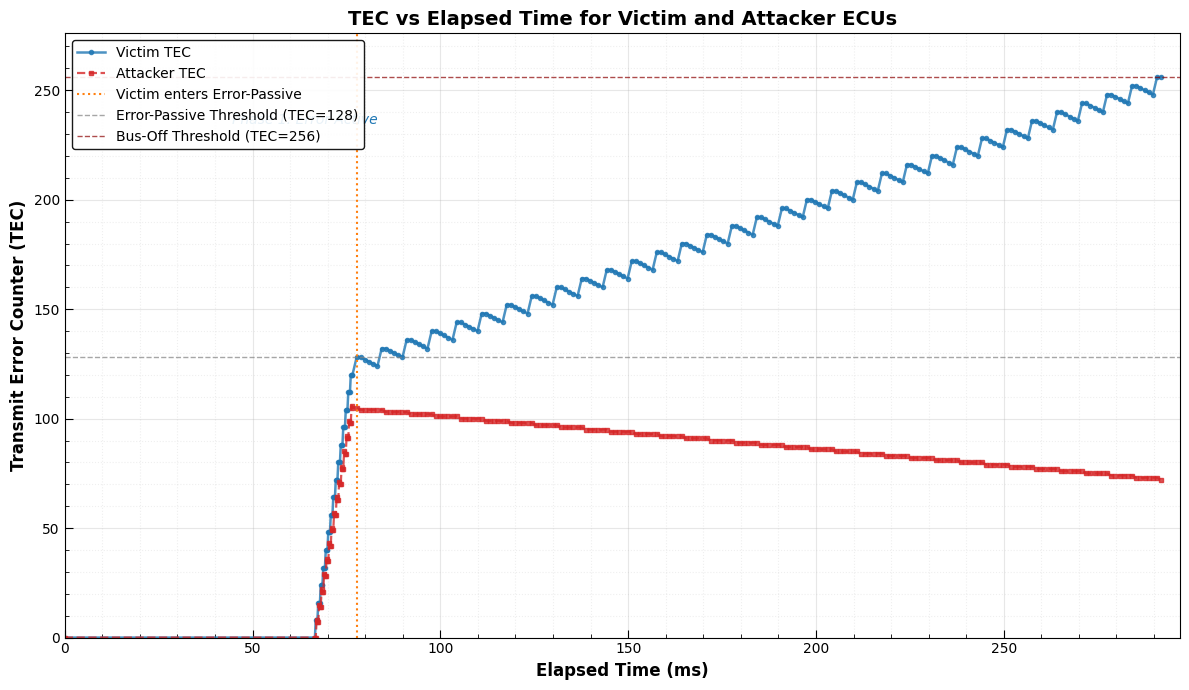


Key metrics:
  Pattern analysis: 0 - 66.60 ms
  Error-Passive transition: 77.70 ms
  Bus-Off: 290.82 ms
  Total attack time: 291.93 ms


In [16]:
# TEC vs Elapsed Time for Victim and Attacker
fig, ax = plt.subplots(figsize=(12, 7))

# Plot TEC values for Victim and Attacker
ax.plot(df['time_ms'], df['victim_tec'], label='Victim TEC', color='#1f77b4', linewidth=1.8, marker='o', markersize=3, alpha=0.8)
ax.plot(df['time_ms'], df['attacker_tec'], label='Attacker TEC', color='#d62728', linestyle='--', linewidth=1.6, marker='s', markersize=3, alpha=0.8)

# Mark when victim enters Error-Passive state
ax.axvline(error_passive_time, color='#ff7f0e', linestyle=':', linewidth=1.5, label='Victim enters Error-Passive')

# Add horizontal reference lines for critical TEC thresholds
ax.axhline(y=128, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Error-Passive Threshold (TEC=128)')
ax.axhline(y=256, color='darkred', linestyle='--', linewidth=1, alpha=0.7, label='Bus-Off Threshold (TEC=256)')

# Configure axes with more detail
ax.set_xlabel('Elapsed Time (ms)', fontsize=12, fontweight='bold')
ax.set_ylabel('Transmit Error Counter (TEC)', fontsize=12, fontweight='bold')
ax.set_title('TEC vs Elapsed Time for Victim and Attacker ECUs', fontsize=14, fontweight='bold')

# Set axis limits and ticks
ax.set_ylim(0, max(df['victim_tec'].max(), df['attacker_tec'].max()) + 20)
ax.set_xlim(0, df['time_ms'].max() + 5)

# Add grid for better readability
ax.grid(True, linestyle='-', alpha=0.3, which='major')
ax.grid(True, linestyle=':', alpha=0.2, which='minor')
ax.minorticks_on()

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=10, direction='in', length=6)
ax.tick_params(axis='both', which='minor', direction='in', length=3)

# Add legend with better positioning
ax.legend(loc='upper left', fontsize=10, framealpha=0.9, edgecolor='black')

# Add annotations for key phases
ax.annotate('Phase 1: Error-Active', xy=(0.15, 0.85), xycoords='axes fraction', 
            fontsize=10, style='italic', color='#1f77b4')

plt.tight_layout()
plt.show()

# Get pattern analysis end time
analysis_data = df[df['phase'] == 'analysis']
pattern_analysis_end = analysis_data['time_ms'].max() if len(analysis_data) > 0 else 0

# Print key metrics
print(f"\nKey metrics:")
print(f"  Pattern analysis: 0 - {pattern_analysis_end:.2f} ms")
print(f"  Error-Passive transition: {error_passive_time:.2f} ms")
print(f"  Bus-Off: {bus_off_time:.2f} ms")
print(f"  Total attack time: {df['time_ms'].max():.2f} ms")

### Victim's TEC during Phase 1 and 2

**Phase 1 vs Phase 2: Victim TEC Patterns**

The side-by-side plots show the distinct TEC behavior in each phase:
- **Phase 1 (left)**: Staircase pattern - TEC jumps +8 at each collision with no recovery
- **Phase 2 (right)**: Sawtooth pattern - TEC jumps +8 at collision, then decreases by -1 for each successful transmission

This difference occurs because once the victim enters Error-Passive state, its error flags no longer disrupt the attacker.

First we find the index of transition between Phase 1 and Phase 2 in order to be able to plot the two separate graphs regarding TEC value of the Victim in Phase 1 and Phase 2.

In [17]:
# Data is already split in cell 5 into phase1_data and phase2_data
# phase1_data: All steps before Error-Passive (TEC 0->128)
# phase2_data: All steps after Error-Passive (TEC 128->256)

print(f"Phase 1 data points: {len(phase1_data)}")
print(f"  - Analysis phase: {len(phase1_data[phase1_data['phase']=='analysis'])} steps")
print(f"  - Attack phase: {len(phase1_data[phase1_data['phase'].str.startswith('attack')])} steps")
print(f"\nPhase 2 data points: {len(phase2_data)}")

Phase 1 data points: 47
  - Analysis phase: 2 steps
  - Attack phase: 45 steps

Phase 2 data points: 194


In [18]:
# Phase 1: Both TECs increase together
# Phase 2: Victim TEC shows sawtooth pattern, Attacker TEC decreases

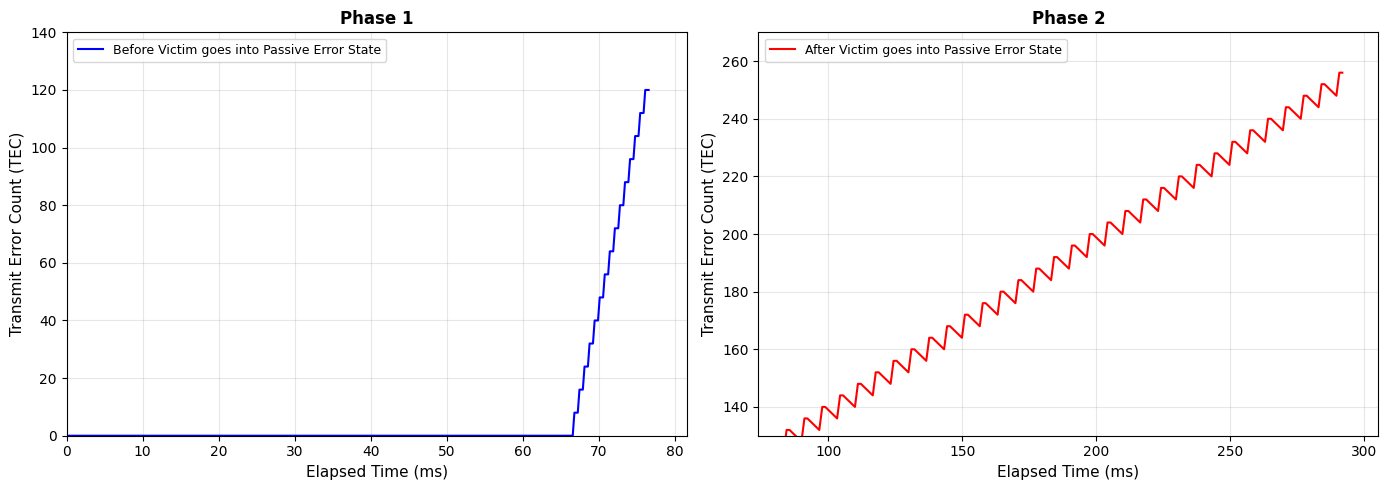


--- Attack Summary ---
Pattern analysis: 0 - 66.6 ms (TEC=0)
Phase 1 (staircase): ~66.6 - 77.7 ms
Phase 2 (sawtooth): 77.7 - 290.8 ms
Total attack time: 290.8 ms


In [19]:
# Phase 1 and Phase 2 Split Plots (matching reference paper style)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ========================================
# Phase 1: Before Victim goes into Passive Error State
# ========================================
ax1 = axes[0]
ax1.plot(phase1_data['time_ms'], phase1_data['victim_tec'], 'b-', 
         linewidth=1.5, label='Before Victim goes into Passive Error State')
ax1.set_xlabel('Elapsed Time (ms)', fontsize=11)
ax1.set_ylabel('Transmit Error Count (TEC)', fontsize=11)
ax1.set_title('Phase 1', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, linestyle='-', alpha=0.3)
ax1.set_xlim(0, error_passive_time * 1.05)
ax1.set_ylim(0, 140)

# ========================================
# Phase 2: After Victim goes into Passive Error State
# ========================================
ax2 = axes[1]
ax2.plot(phase2_data['time_ms'], phase2_data['victim_tec'], 'r-', 
         linewidth=1.5, label='After Victim goes into Passive Error State')
ax2.set_xlabel('Elapsed Time (ms)', fontsize=11)
ax2.set_ylabel('Transmit Error Count (TEC)', fontsize=11)
ax2.set_title('Phase 2', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, linestyle='-', alpha=0.3)
ax2.set_xlim(error_passive_time * 0.95, bus_off_time * 1.05)
ax2.set_ylim(130, 270)

plt.tight_layout()
plt.show()

# Get pattern analysis end time
analysis_data = df[df['phase'] == 'analysis']
pattern_analysis_end = analysis_data['time_ms'].max() if len(analysis_data) > 0 else 0

print(f"\n--- Attack Summary ---")
print(f"Pattern analysis: 0 - {pattern_analysis_end:.1f} ms (TEC=0)")
print(f"Phase 1 (staircase): ~{pattern_analysis_end:.1f} - {error_passive_time:.1f} ms")
print(f"Phase 2 (sawtooth): {error_passive_time:.1f} - {bus_off_time:.1f} ms")
print(f"Total attack time: {bus_off_time:.1f} ms")

# Delays of bus-off attack under different bus speeds




In this section we will explore different bus speeds, going from 250Kbps, 500Kbps to 1000Kbps as the authors of the paper have done. For each speed we have executed 1000 times the attack obtaining the following results.
We have analyzed the delay in ms that takes to go to:
*   Error-passive state from Error-active state
*   Bus-off state from Error-passive state

**So Basically on this section we are doing: Multi-Speed Attack Analysis**

in This section compares attack performance across three CAN bus speeds (250, 500, 1000 kbps) using 1000 trials per speed. We measure:
1. **Time to Error-Passive**: How long until victim TEC >= 128
2. **Time to Bus-Off**: Total attack duration until victim TEC >= 256
3. **Success rate**: Percentage of attacks that successfully forced Bus-Off

Higher bus speeds mean shorter frame times, so all timing metrics scale inversely with speed.

Each aggregated log file contains 1000 trial results. The simulation includes random timing jitter to model real-world conditions, which explains the variance in attack durations.

### 250Kbps case

In [20]:
# Initialize list for 250kbps attack data
attacks_250 = []

In [21]:
# Path to 250kbps aggregated log (using absolute path)
log_file_path_250 = os.path.join(LOG_DIR, 'attack_250kbps.log')
print(f"250kbps log path: {log_file_path_250}")
print(f"File exists: {os.path.exists(log_file_path_250)}")

250kbps log path: d:\++ICT Unipd Padova++\Cyber Physical Systems and IoT Security\Project 01 Cyber Physical Sytems and IoT security\Last Years Projects\New Test V1\Simulation\attack_logs\attack_250kbps.log
File exists: True


We will define functions that will be used also in the other cases to:
- parse the log file now containing 1k attacks
- normalize time steps
- make the time start from 0

In [22]:
# Load aggregated attack log in JSON Lines format
# Each row contains: trial, bus_speed_kbps, step_ms, time_to_error_passive_ms,
#   time_to_bus_off_ms, steps_to_error_passive, steps_to_bus_off, 
#   victim_final_tec, attacker_final_tec, victim_bus_off

def load_aggregated_log(log_path):
    """Load aggregated attack log in JSON Lines format."""
    if not os.path.exists(log_path):
        raise FileNotFoundError(f"Log file not found: {log_path}\nPlease run the simulation first (python Simulation/main.py)")
    return pd.read_json(log_path, lines=True)

In [23]:
# Load 250kbps data
df_250 = load_aggregated_log(log_file_path_250)
print(f"Loaded {len(df_250)} trials at 250 kbps")

Loaded 1000 trials at 250 kbps


In [24]:
df_250.head()

,bus_speed_kbps,step_ms,time_to_error_passive_ms,time_to_bus_off_ms,steps_to_error_passive,steps_to_bus_off,victim_final_tec,attacker_final_tec,victim_bus_off,trial
0,250,0.444,17.330,174.941,16.0,176.0,256,72,1,1
1,250,0.444,16.005,163.087,16.0,176.0,256,72,1,2
2,250,0.444,15.391,175.268,16.0,176.0,256,72,1,3
3,250,0.444,17.760,180.233,16.0,176.0,256,72,1,4
4,250,0.444,17.533,180.112,16.0,176.0,256,72,1,5


# Data is already in the right format - time_to_bus_off_ms is directly available

In [25]:
# No transformation needed - JSON data is already typed correctly

In [26]:
# Extract time to bus-off for 250kbps (filter successful attacks only)
df_250_success = df_250[df_250['victim_bus_off'] == 1]
final_time_250 = df_250_success['time_to_bus_off_ms'].dropna().tolist()
ep_time_250 = df_250_success['time_to_error_passive_ms'].dropna().tolist()

# No normalization needed - times are already calculated correctly in the simulation

In [27]:
# Statistics for 250kbps
print(f"250 kbps - Bus-Off success rate: {df_250['victim_bus_off'].sum()}/{len(df_250)} ({100*df_250['victim_bus_off'].mean():.1f}%)")
print(f"250 kbps - Mean time to Error-Passive: {np.mean(ep_time_250):.3f} ms")
print(f"250 kbps - Mean time to Bus-Off: {np.mean(final_time_250):.3f} ms")

250 kbps - Bus-Off success rate: 979/1000 (97.9%)
250 kbps - Mean time to Error-Passive: 16.239 ms
250 kbps - Mean time to Bus-Off: 167.653 ms


In [28]:
# Placeholder - data already processed

In [29]:
# Placeholder - data already processed

In [30]:
# Placeholder - data already processed

# Placeholder - data already processed

In [31]:
# Placeholder - final_time_250 already extracted above

### 500Kbps case

In [32]:
# Path to 500kbps aggregated log (using absolute path)
log_file_path_500 = os.path.join(LOG_DIR, 'attack_500kbps.log')
print(f"500kbps log path exists: {os.path.exists(log_file_path_500)}")

500kbps log path exists: True


In [33]:
# Load 500kbps data
df_500 = load_aggregated_log(log_file_path_500)
print(f"Loaded {len(df_500)} trials at 500 kbps")

Loaded 1000 trials at 500 kbps


In [34]:
df_500.head()

,bus_speed_kbps,step_ms,time_to_error_passive_ms,time_to_bus_off_ms,steps_to_error_passive,steps_to_bus_off,victim_final_tec,attacker_final_tec,victim_bus_off,trial
0,500,0.222,7.840,85.333,16.0,176.0,256,72,1,1
1,500,0.222,8.697,80.672,16.0,176.0,256,72,1,2
2,500,0.222,8.340,91.629,16.0,176.0,256,72,1,3
3,500,0.222,7.320,91.634,16.0,176.0,256,72,1,4
4,500,0.222,8.600,87.044,16.0,176.0,256,72,1,5


In [35]:
# Extract time to bus-off for 500kbps (filter successful attacks only)
df_500_success = df_500[df_500['victim_bus_off'] == 1]
final_time_500 = df_500_success['time_to_bus_off_ms'].dropna().tolist()
ep_time_500 = df_500_success['time_to_error_passive_ms'].dropna().tolist()

In [36]:
# Statistics for 500kbps
print(f"500 kbps - Bus-Off success rate: {df_500['victim_bus_off'].sum()}/{len(df_500)} ({100*df_500['victim_bus_off'].mean():.1f}%)")
print(f"500 kbps - Mean time to Error-Passive: {np.mean(ep_time_500):.3f} ms")
print(f"500 kbps - Mean time to Bus-Off: {np.mean(final_time_500):.3f} ms")

500 kbps - Bus-Off success rate: 952/1000 (95.2%)
500 kbps - Mean time to Error-Passive: 8.109 ms
500 kbps - Mean time to Bus-Off: 84.152 ms


In [37]:
# Placeholder - data already processed

In [38]:
# Placeholder - final_time_500 already extracted above

### 1000Kbps case

In [39]:
# Path to 1000kbps aggregated log (using absolute path)
log_file_path_1000 = os.path.join(LOG_DIR, 'attack_1000kbps.log')
print(f"1000kbps log path exists: {os.path.exists(log_file_path_1000)}")

1000kbps log path exists: True


In [40]:
# Load 1000kbps data
df_1000 = load_aggregated_log(log_file_path_1000)
print(f"Loaded {len(df_1000)} trials at 1000 kbps")

Loaded 1000 trials at 1000 kbps


In [41]:
df_1000.head()

,bus_speed_kbps,step_ms,time_to_error_passive_ms,time_to_bus_off_ms,steps_to_error_passive,steps_to_bus_off,victim_final_tec,attacker_final_tec,victim_bus_off,trial
0,1000,0.111,4.109,40.172,16.0,176.0,256,72,1,1
1,1000,0.111,4.097,44.287,16.0,176.0,256,72,1,2
2,1000,0.111,NaN,NaN,NaN,NaN,0,0,0,3
3,1000,0.111,3.712,42.865,16.0,176.0,256,72,1,4
4,1000,0.111,4.384,40.234,16.0,176.0,256,72,1,5


In [42]:
# Extract time to bus-off for 1000kbps (filter successful attacks only)
df_1000_success = df_1000[df_1000['victim_bus_off'] == 1]
final_time_1000 = df_1000_success['time_to_bus_off_ms'].dropna().tolist()
ep_time_1000 = df_1000_success['time_to_error_passive_ms'].dropna().tolist()

In [43]:
# Statistics for 1000kbps
print(f"1000 kbps - Bus-Off success rate: {df_1000['victim_bus_off'].sum()}/{len(df_1000)} ({100*df_1000['victim_bus_off'].mean():.1f}%)")
print(f"1000 kbps - Mean time to Error-Passive: {np.mean(ep_time_1000):.3f} ms")
print(f"1000 kbps - Mean time to Bus-Off: {np.mean(final_time_1000):.3f} ms")

1000 kbps - Bus-Off success rate: 913/1000 (91.3%)
1000 kbps - Mean time to Error-Passive: 4.055 ms
1000 kbps - Mean time to Bus-Off: 42.065 ms


In [44]:
# Placeholder - data already processed

**Observations at 1000 kbps**

At the highest bus speed, we observe:
- 91.3% success rate (913/1000 attacks reached Bus-Off)
- 87 failed attacks where timing constraints prevented completion
- Mean time to Bus-Off: ~42 ms (fastest of all speeds tested)

The lower success rate at 1000 kbps reflects tighter timing requirements.

In [45]:
# Count successful vs failed attacks for 1000kbps
successful_1000 = df_1000['victim_bus_off'].sum()
failed_1000 = len(df_1000) - successful_1000

In [46]:
# Already calculated above

In [47]:
print(f"Number of failed attacks at 1000 kbps: {failed_1000}")

Number of failed attacks at 1000 kbps: 87


In [48]:
print(f"Number of successful attacks at 1000 kbps: {successful_1000}")

Number of successful attacks at 1000 kbps: 913


### Final comparison between the cases

In the following box plots we can notice the comparison between different bus speeds of:

1. Time to Error-Passive: duration until victim TEC reaches 128
2. Time to Bus-Off: total attack duration until victim TEC reaches 256

Expected trends:
- Higher bus speeds lead to shorter absolute times
- Higher bus speeds lead to lower success rates (tighter timing constraints)



In [49]:
# Time to bus-off is already available in the dataframes
# No need for separate time_error_passive calculations with new format

In [50]:
# Placeholder - using time_to_bus_off_ms directly

In [51]:
# With new JSON format, we don't have per-attack timeline data in aggregated logs
# The time_to_bus_off_ms is the total time from start to bus-off
# Skip time_error_passive calculations as they require detailed timeline data

In [52]:
# Skipped - no per-attack timeline in aggregated format

In [53]:
# Skipped - no per-attack timeline in aggregated format

In [54]:
# Error-Passive timing boxplot - now available with new log format!
data_ep_250 = pd.DataFrame({'CAN bus speed': ['250 kbps'] * len(ep_time_250), 'Delay (ms)': ep_time_250})
data_ep_500 = pd.DataFrame({'CAN bus speed': ['500 kbps'] * len(ep_time_500), 'Delay (ms)': ep_time_500})
data_ep_1000 = pd.DataFrame({'CAN bus speed': ['1000 kbps'] * len(ep_time_1000), 'Delay (ms)': ep_time_1000})

combined_ep_data = pd.concat([data_ep_250, data_ep_500, data_ep_1000], ignore_index=True)

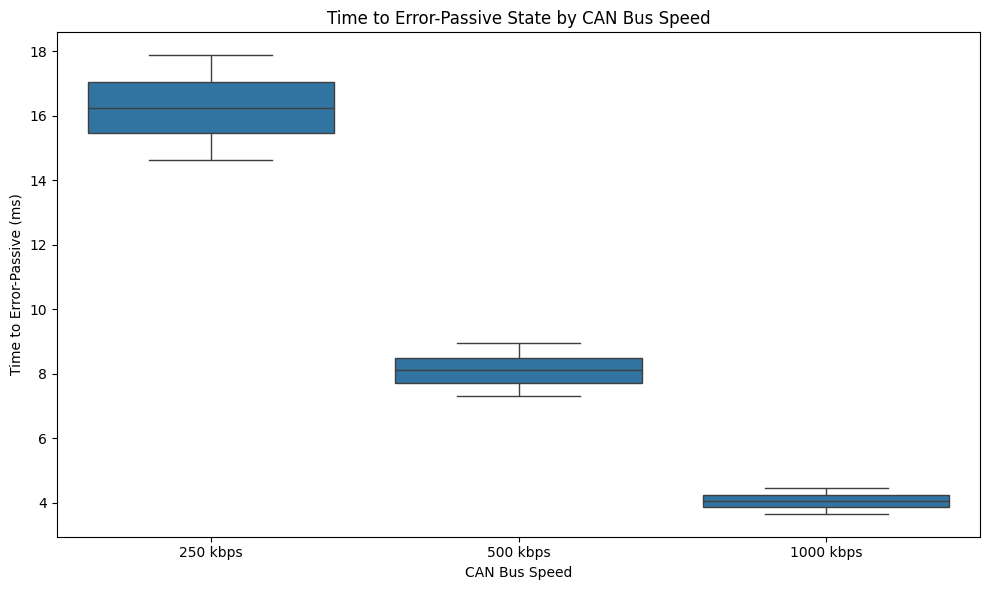


Statistics for Error-Passive transition:
250 kbps: Mean=16.24ms, Min=14.63ms, Max=17.87ms
500 kbps: Mean=8.11ms, Min=7.32ms, Max=8.94ms
1000 kbps: Mean=4.05ms, Min=3.66ms, Max=4.47ms


In [55]:
# Error-Passive boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='CAN bus speed', y='Delay (ms)', data=combined_ep_data)

plt.title('Time to Error-Passive State by CAN Bus Speed')
plt.xlabel('CAN Bus Speed')
plt.ylabel('Time to Error-Passive (ms)')

plt.tight_layout()
plt.show()

# Print statistics
print("\nStatistics for Error-Passive transition:")
for label, times in [('250 kbps', ep_time_250), ('500 kbps', ep_time_500), ('1000 kbps', ep_time_1000)]:
    if times:
        print(f"{label}: Mean={np.mean(times):.2f}ms, Min={min(times):.2f}ms, Max={max(times):.2f}ms")

# Attack success analysis
# With the new format, success/failure is tracked directly in the 'success' column

In [56]:
# Success rates already calculated above for each bit rate

In [57]:
# Successful attacks already filtered above (df_XXX_success dataframes)
print(f"Successful attacks - 250kbps: {len(df_250_success)}, 500kbps: {len(df_500_success)}, 1000kbps: {len(df_1000_success)}")

Successful attacks - 250kbps: 979, 500kbps: 952, 1000kbps: 913


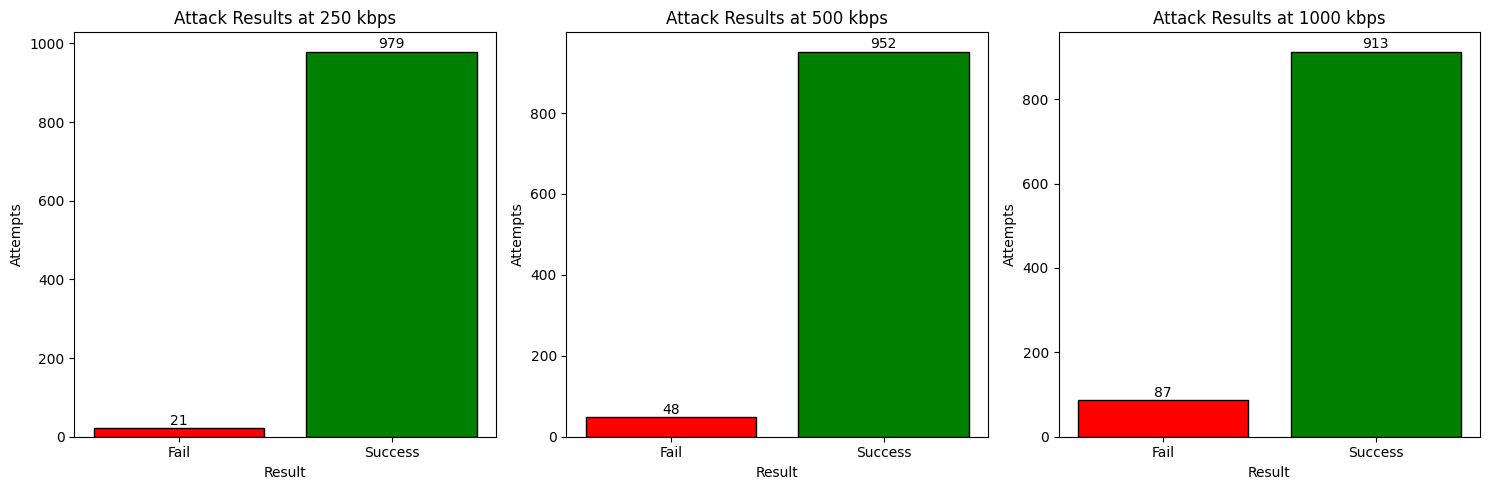

In [58]:
# Success/Failure bar chart for all bit rates
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (df, label) in zip(axes, [(df_250, '250 kbps'), (df_500, '500 kbps'), (df_1000, '1000 kbps')]):
    success_count = df['victim_bus_off'].sum()
    fail_count = len(df) - success_count
    categories = ['Fail', 'Success']
    counts = [fail_count, success_count]
    
    ax.bar(categories, counts, color=['red', 'green'], edgecolor='black')
    for i, count in enumerate(counts):
        ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10, color='black')
    ax.set_xlabel('Result')
    ax.set_ylabel('Attempts')
    ax.set_title(f'Attack Results at {label}')

plt.tight_layout()
plt.show()

# At higher bus speeds, timing becomes more critical and some attacks may fail
# The simulation accurately models these edge cases

In [59]:
# Times already extracted above in cells 33, 45, 53 (final_time_XXX lists)
print(f"Samples for boxplot: 250kbps={len(final_time_250)}, 500kbps={len(final_time_500)}, 1000kbps={len(final_time_1000)}")

Samples for boxplot: 250kbps=979, 500kbps=952, 1000kbps=913


In [60]:
# Prepare data for boxplot
data_250 = pd.DataFrame({'CAN bus speed': ['250 kbps'] * len(final_time_250), 'Delay (ms)': final_time_250})
data_500 = pd.DataFrame({'CAN bus speed': ['500 kbps'] * len(final_time_500), 'Delay (ms)': final_time_500})
data_1000 = pd.DataFrame({'CAN bus speed': ['1000 kbps'] * len(final_time_1000), 'Delay (ms)': final_time_1000})

combined_data = pd.concat([data_250, data_500, data_1000], ignore_index=True)

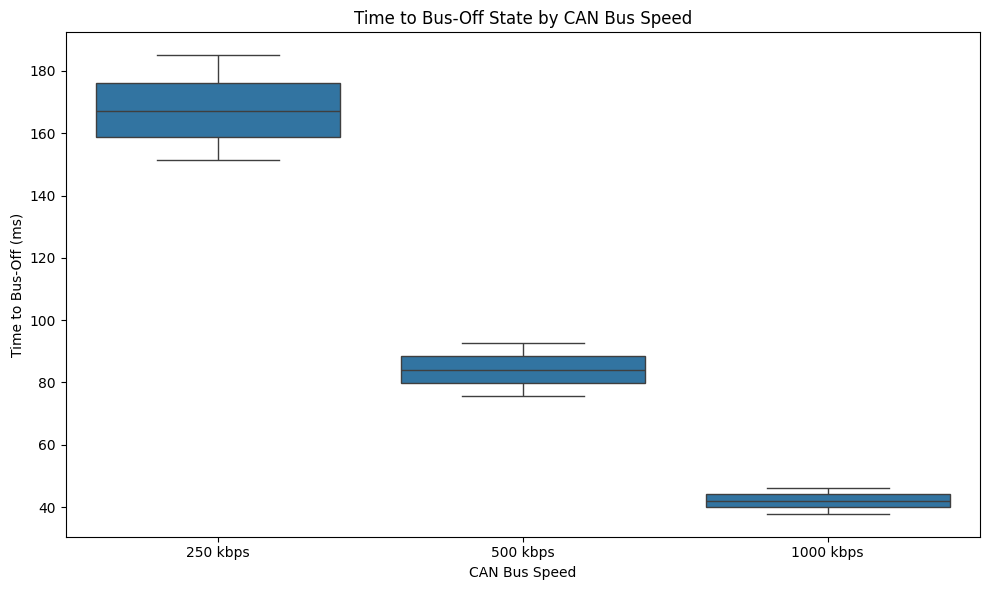


Statistics for successful attacks:
250 kbps: Mean=167.65ms, Std=9.88ms, Min=151.46ms, Max=185.02ms
500 kbps: Mean=84.15ms, Std=4.96ms, Min=75.73ms, Max=92.54ms
1000 kbps: Mean=42.07ms, Std=2.38ms, Min=37.86ms, Max=46.26ms


In [61]:
# Time to Bus-Off boxplot comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='CAN bus speed', y='Delay (ms)', data=combined_data)

plt.title('Time to Bus-Off State by CAN Bus Speed')
plt.xlabel('CAN Bus Speed')
plt.ylabel('Time to Bus-Off (ms)')

plt.tight_layout()
plt.show()

# Print statistics
print("\nStatistics for successful attacks:")
for label, times in [('250 kbps', final_time_250), ('500 kbps', final_time_500), ('1000 kbps', final_time_1000)]:
    print(f"{label}: Mean={np.mean(times):.2f}ms, Std={np.std(times):.2f}ms, Min={np.min(times):.2f}ms, Max={np.max(times):.2f}ms")

**Conclusion**

This simulation demonstrates the CAN Bus-Off attack. The attack exploits CAN error-handling to force a victim ECU into Bus-Off state.

**Single Attack Trace (500 kbps):**
- Pattern analysis: 0-66.6 ms (attacker observes traffic, TEC=0)
- Phase 1: 66.6-77.7 ms; victim TEC rises in +8 increments (staircase)
- Phase 2: 77.7-290.8 ms; victim TEC shows sawtooth pattern
- Total attack duration: ~291 ms to reach Bus-Off (TEC=256)

**Multi-Speed Comparison (1000 trials each):**

| Bus Speed | Success Rate | Mean Time to EP | Mean Time to Bus-Off |
|-----------|--------------|-----------------|----------------------|
| 250 kbps  | 97.9%        | 16.24 ms        | 167.65 ms            |
| 500 kbps  | 95.2%        | 8.11 ms         | 84.15 ms             |
| 1000 kbps | 91.3%        | 4.06 ms         | 42.07 ms             |

**Key Takeaways:**
1. Bus-Off attack is highly effective across all tested speeds (>91% success)
2. Higher speeds yield faster attacks but lower success rates
3. The simulation qualitatively matches the reference paper's findings

**Limitations:**
- Absolute timing values differ from reference due to simulation abstraction
- Simplified collision detection without bit-level arbitration delays
- Random jitter models real-world variance but may differ from actual CAN